In [3]:
import scipy.io
#-------画像データ読み込み-----------------------
mat = scipy.io.loadmat('eA10_3CL.mat');

#--データファイルの説明---------------------------
#
#+++++++[1]データ形式++++++++++++++++++++++++++++
#  データはmatlabの(.mat)形式で、構造体(仮に変数名をtmpとする)
#  として下記の4変数が格納されています。
#  (1)tmp.x1 = train画像群(600, 64, 64, 3)　
#  (2)tmp.x2 = test画像群(60, 64, 64, 3)
#  (3)tmp.y1 = train注釈：分類ラベル(600,1) 
#  (4)tmp.y2 = test注釈:分類ラベル(60,1)
#
#++++++[2]画像データ(x1,x2)+++++++++++++++++++++++
#  1つの画像は縦横が64,64で、RGBの3チャネルです。各画像
#  サイズは(64,64,3)になります。train画像群の場合は
#  600枚を一つの変数x1に入れたので、変数のサイズは
# (600,64,64,3)になります。
#
#+++++[3]分類ラベルデータ(y1,y2)+++++++++++++++++++++++  
#  画像注釈の分類ラベルには、クラス番号（0,1,2）が格納されています。
#
#+++++[4]訓練データ変数の作成+++++++++++++++++++++++++
#  訓練データの変数の作成（tmp.x1からx_trainへの変換名変更）は、
#  後続セルの「画像データ(X)と注釈(Y)準備」を参照してください
#

In [27]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

#-----学習用パラメータ-------------------
batch_size = 256 #128
num_classes = 3
epochs = 6 #12

#----画像サイズ設定------------------- 
img_rows, img_cols = 64, 64
input_shape = (img_rows, img_cols, 3)

#----画像データ(X)と注釈(Y)準備------------ 
x_train = mat['x1']
x_test = mat['x2']
y_train = mat['y1']
y_test = mat['y2']

#-----画像データのRGB値を[0-1]に変換----------------------
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

#----クラス番号0,1,2をバイナリ[1,0,0][0,1,0][0,0,1]に変換-------
y_test_org = y_test
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


#--------modelの定義------------------------------------- 
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), 
                 input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',#損失関数
              optimizer='adam', #最適化手法
              metrics=['accuracy']) #評価関数

#--------modelを学習----------------------------------
history=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

#--------modelの評価---------------------------------
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: %0.03f' % score[0])
print('Test accuracy: %0.03f' % score[1])

x_train shape: (600, 64, 64, 3)
600 train samples
60 test samples
Train on 600 samples, validate on 60 samples
Epoch 1/6
600/600 [==============================] - 23s - loss: 1.0871 - acc: 0.3633 - val_loss: 0.9908 - val_acc: 0.5667
Epoch 2/6
600/600 [==============================] - 27s - loss: 0.9675 - acc: 0.4583 - val_loss: 0.7648 - val_acc: 0.5333
Epoch 3/6
600/600 [==============================] - 28s - loss: 0.8542 - acc: 0.5483 - val_loss: 0.7963 - val_acc: 0.7000
Epoch 4/6
600/600 [==============================] - 29s - loss: 0.8586 - acc: 0.5400 - val_loss: 0.7128 - val_acc: 0.7000
Epoch 5/6
600/600 [==============================] - 35s - loss: 0.8252 - acc: 0.6150 - val_loss: 0.6850 - val_acc: 0.7333
Epoch 6/6
600/600 [==============================] - 34s - loss: 0.8030 - acc: 0.6300 - val_loss: 0.7392 - val_acc: 0.7333
Test loss: 0.739
Test accuracy: 0.733


評価尺度Accuracyの定義
$$
\begin{eqnarray}
Accuracy &=& {\frac{TP+FN}{TP+FP+TN+FN}} 
\end{eqnarray}
$$

$$
\begin{array}{|c||c|c|}
　　 & Predicted:YES & Predicted:NO \\\hline 
Actual:YES & [True~Positive(TP)] &[False~Negative(FN)] \\\
Actual:NO & [False~Positive(FP)] &
[True~Negative(TN)]
\end{array}
$$

In [33]:
y_pred = model.predict_classes(x_test) #予測値y_predの計算


60/60 [==============================] - 0s     


In [46]:
#--混同行列の計算 ----------------------
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print(y_pred.shape)
print(y_test_org.shape)
pd.crosstab(y_test_org.flatten(),y_pred,rownames=['True'],colnames=['Pred'],margins=True) #混同行列


(60,)
(60, 1)


Pred,0,1,2,All
True,,,,
0,14,1,5,20
1,2,13,5,20
2,0,3,17,20
All,16,17,27,60


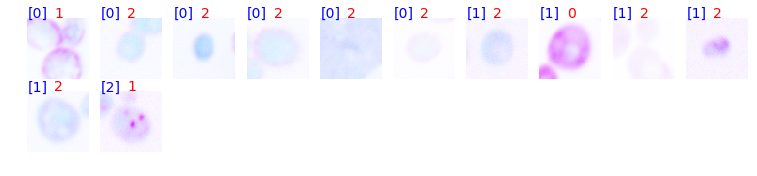

In [22]:
#---不正解ラベルの画像を視覚化-------------------------

import matplotlib.pyplot as plt
%matplotlib inline 

test_wrong = [im for im in zip(x_test,y_pred,y_test_org) if im[1] != im[2]]

plt.figure(figsize=(10, 10))
for ind, val in enumerate(test_wrong[:20]):
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.subplot(10, 10, ind + 1)
    im = 1 - val[0].reshape((64,64,3))
    plt.axis("off")
    plt.text(0, 0, val[2], fontsize=14, color='blue')#正解ラベル
    plt.text(28, 0, val[1], fontsize=14, color='red')#予測ラベル
    plt.imshow(im, cmap='gray')

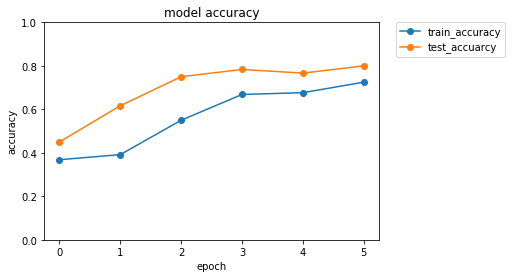

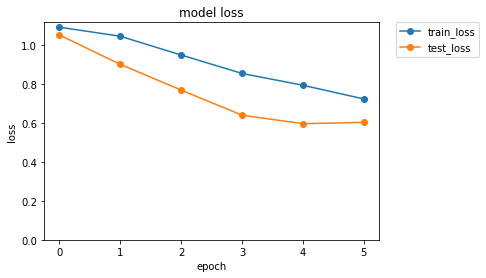

In [24]:
#---評価関数(Accuracy)の変化を視覚化----------------------
plt.plot(history.history['acc'],"o-",label="train_accuracy")
plt.plot(history.history['val_acc'],"o-",label="test_accuarcy")
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

#---損失関数の変化を視覚化----------------------
plt.plot(history.history['loss'],"o-",label="train_loss",)
plt.plot(history.history['val_loss'],"o-",label="test_loss")
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(ymin=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [16]:
#----model architectureを確認---------------------
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 60, 60, 32)        9248      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 58, 58, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 27, 27, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 25, 25, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 64)        0         
__________